In [34]:
import sys
!{sys.executable} -m pip install -r ../requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 92.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [46]:
import boto3
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tf2onnx
import onnx

In [4]:
# s3_client = boto3.client('s3')
# response = s3_client.get_object(Bucket="gmidha-bigdata-nov07", Key="msftdata.csv")

# status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

# if status == 200:
#     print(f"Successful S3 get_object response. Status - {status}")
#     msft_df = pd.read_csv(response.get("Body"))
#     print(msft_df)
# else:
#     print(f"Unsuccessful S3 get_object response. Status - {status}")

NoCredentialsError: Unable to locate credentials

In [4]:
# conn = trino.dbapi.connect(
#         host,
#         port,
#         http_scheme='http',
#         user='admin'
#         )

In [47]:
start_date = '2019-02-01'
end_date = '2024-02-01'
#d = data.DataReader(name='TSLA', data_source='yahoo', start=start_date, end=end_date)

data = web.DataReader(name="TSLA", data_source='yahoo', start=start_date, end=end_date)
print(data)

TypeError: string indices must be integers

In [28]:
msft = pd.read_csv("../msftdata.csv")

In [29]:

msft.shape

(1257, 6)

In [30]:
msft.head()

,tradedate,close,volume,open,high,low
0,2018-08-30,111.95,22759640,111.67,112.61,111.44
1,2018-08-31,112.33,23217310,111.69,112.78,111.52
2,2018-09-04,111.71,22558040,110.85,111.96,110.22
3,2018-09-05,108.49,32838650,111.01,111.42,108.10
4,2018-09-06,108.74,23226430,108.25,108.99,107.51


In [31]:
msft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tradedate  1257 non-null   object 
 1   close      1257 non-null   float64
 2   volume     1257 non-null   int64  
 3   open       1257 non-null   float64
 4   high       1257 non-null   float64
 5   low        1257 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 59.0+ KB


In [5]:
# cur = conn.cursor()
# cur.execute('SELECT * FROM s3.default.msft')
# rows = cur.fetchall()

# msft = pd.DataFrame(rows)
# msft.columns = ['tradedate', 'close', 'volume', 'open', 'high', 'low']
# msft



,tradedate,close,volume,open,high,low
0,2018-08-30,111.95,22759640,111.67,112.61,111.44
1,2018-08-31,112.33,23217310,111.69,112.78,111.52
2,2018-09-04,111.71,22558040,110.85,111.96,110.22
3,2018-09-05,108.49,32838650,111.01,111.42,108.10
4,2018-09-06,108.74,23226430,108.25,108.99,107.51
...,...,...,...,...,...,...
1252,2023-08-23,327.00,21166380,323.82,329.20,323.46
1253,2023-08-24,319.97,23281430,332.85,332.98,319.96
1254,2023-08-25,322.98,21684100,321.47,325.36,318.80
1255,2023-08-28,323.70,14808480,325.66,326.15,321.72


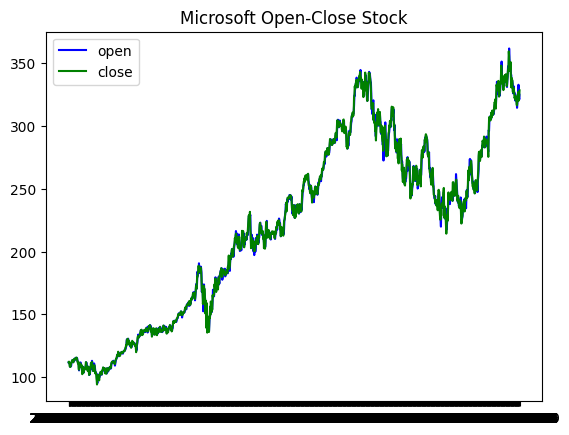

In [6]:
plt.plot(msft['tradedate'],msft['open'],color="blue",label="open")
plt.plot(msft['tradedate'],msft['close'],color="green", label="close")
plt.title("Microsoft Open-Close Stock")
plt.legend()

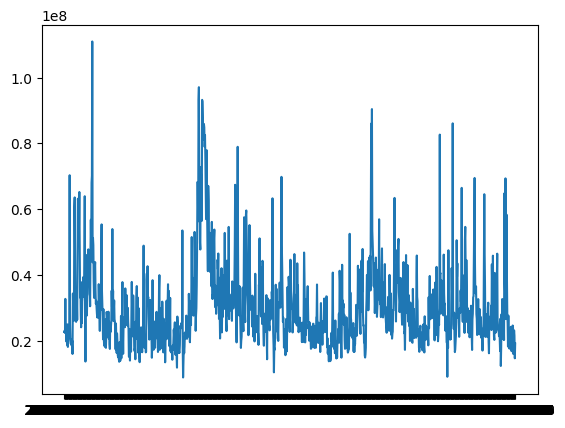

In [7]:
plt.plot(msft['tradedate'],msft['volume'])
plt.show()

In [25]:
close_data = msft.filter(['close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .7))
print(training)

880


In [9]:

 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
 
train_data = scaled_data[0:int(training), :]

# prepare feature and labels
x_train = []
y_train = []
 
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [10]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
                            return_sequences=True,
                            input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x7f082027a460>>

In [11]:
model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=10)

Epoch 1/10
26/26 [==============================] - 3s 31ms/step - loss: 0.0380
Epoch 2/10
26/26 [==============================] - 1s 32ms/step - loss: 0.0124
Epoch 3/10
26/26 [==============================] - 1s 31ms/step - loss: 0.0095
Epoch 4/10
26/26 [==============================] - 1s 30ms/step - loss: 0.0082
Epoch 5/10
26/26 [==============================] - 1s 30ms/step - loss: 0.0088
Epoch 6/10
26/26 [==============================] - 1s 30ms/step - loss: 0.0080
Epoch 7/10
26/26 [==============================] - 1s 30ms/step - loss: 0.0081
Epoch 8/10
26/26 [==============================] - 1s 29ms/step - loss: 0.0078
Epoch 9/10
26/26 [==============================] - 1s 31ms/step - loss: 0.0077
Epoch 10/10
26/26 [==============================] - 1s 30ms/step - loss: 0.0078


In [12]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
 
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
 
# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
 
# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

12/12 [==============================] - 1s 9ms/step
MSE 121.59198393661997
RMSE 11.02687552920681


/tmp/ipykernel_153/433301594.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


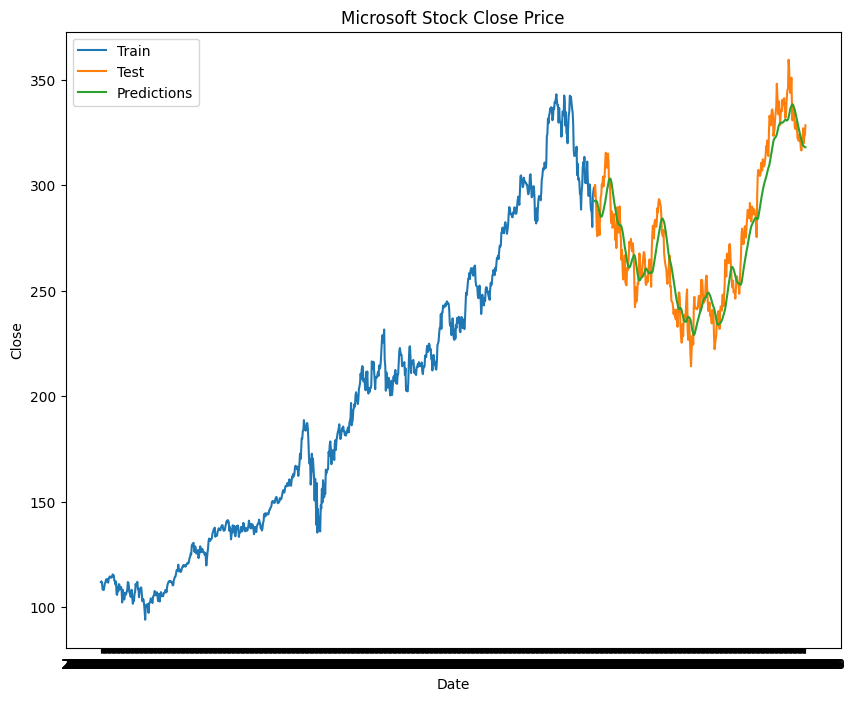

In [13]:
train = msft[:training]
test = msft[training:]
test['Predictions'] = predictions
 
plt.figure(figsize=(10, 8))
plt.plot(train['tradedate'], train['close'])
plt.plot(test['tradedate'], test[['close', 'Predictions']])
plt.title('Microsoft Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])

In [14]:
model.save("../stock_predict.keras")